# GradCam

Grad-CAM (Gradient-weighted Class Activation Mapping) is a generalization of the class activation mapping (CAM) technique that produces heatmaps that show which parts of an image were important for a neural network’s classification decision. 

It is mostly useful for Image classification, but also can be applied to Semantic Segmentation and Object Detection(with some modifications).

## Image classification

#### PyTorch models

In [2]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import requests

Ok, let's firstly define the model. We can just use the model straight from the PyTorch library without any changes in the architecture.

In [ ]:
model = models.resnet50(pretrained=True)
model.eval()

Donwload image and normalise it to the range [0, 1]. Also, creating input tensor for the model.

Be careful with preprocess_image function for creating input tensor, since for your target model you may need to change something. 

In [24]:
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

# input tensor using preprocess_image function from pytorch_grad_cam
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

One big problem with GradCam is that it is not easy to understand which layer to use for the target model.

Typically, you can just google it for the popular models or give it a try. 

In [ ]:
# As usual for classication, the target is the logit output
# before softmax, for that category.
target_layers = [model.layer4]

Let's define our target class to explain the model. Here is also a script to quickly check ImageNet classes. 

In [30]:
response = requests.get('https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt')
class_names = [line.strip() for line in response.text.split('\n')]

# Target class is the Bear ofcourse :)
targets = [ClassifierOutputTarget(295)]

# Check if we set the id correctly
print("1: ", class_names[1])
print("295: ", class_names[295])

1:  goldfish, Carassius auratus
295:  American black bear, black bear, Ursus americanus, Euarctos americanus


Finally, GradCam

Model output:  tensor(294)


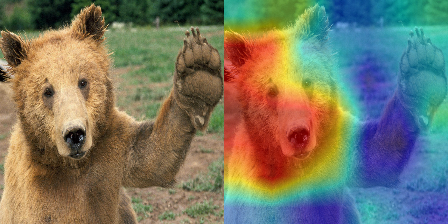

In [35]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

# Let's stack image and visualized CAM side by side
print("Model output: ", model(input_tensor).argmax())
images = np.hstack((np.uint8(255*img), cam_image))
Image.fromarray(images)

#### 🤗 HuggingFace library

HuggingFace library is a home not only for the NLP models, so here are a bunch of examples **including ViT**

In [13]:
from pytorch_grad_cam import run_dff_on_image, GradCAM
from datasets import load_dataset
# import pytorch transfoms 
from torchvision import transforms

Load cat's dataset 🐈

In [14]:
dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]
img_tensor = transforms.ToTensor()(image)

No config specified, defaulting to: cats-image/image
Found cached dataset cats-image (/Users/nkise/.cache/huggingface/datasets/huggingface___cats-image/image/1.9.0/68fbc793fb10cd165e490867f5d61fa366086ea40c73e549a020103dcb4f597e)
100%|██████████| 1/1 [00:00<00:00, 368.86it/s]


Setup a couple of functions to work with categories names. 

In [18]:
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

#### ResNet 50

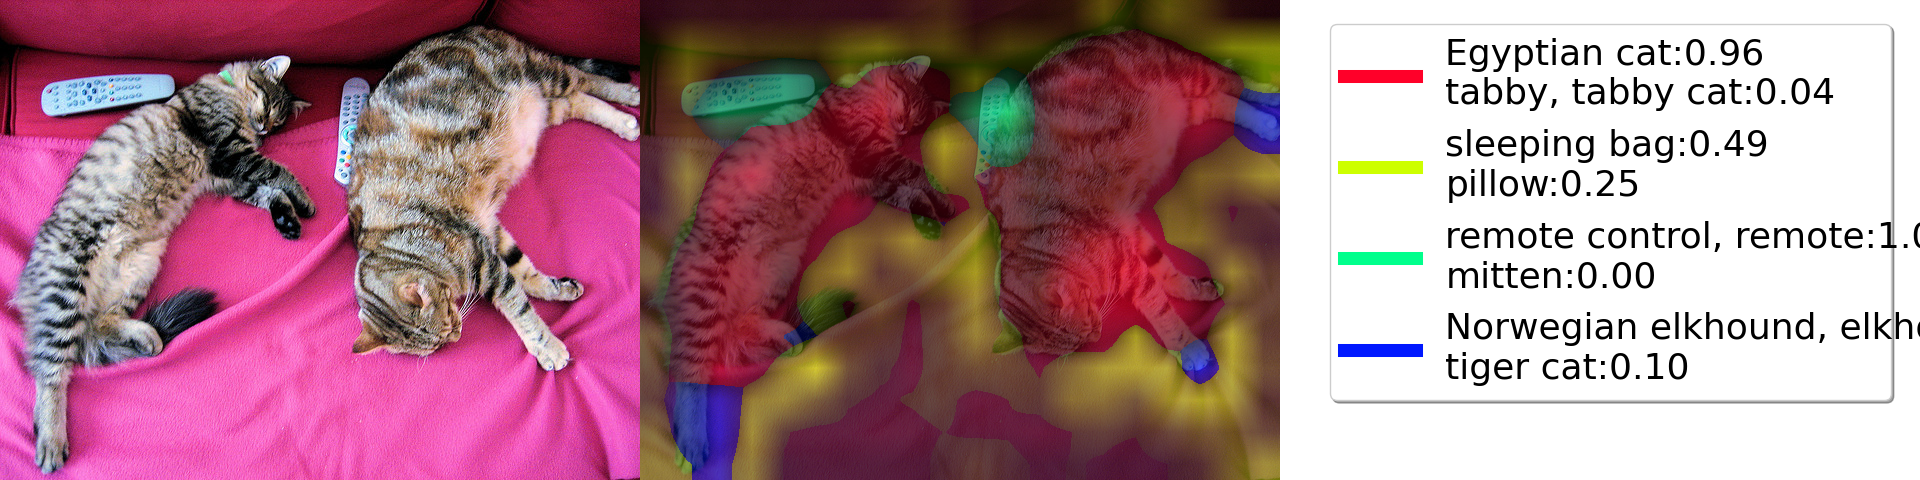

Predicted class 761: remote control, remote
Predicted class 282: tiger cat
Predicted class 285: Egyptian cat
Predicted class 281: tabby, tabby cat
Predicted class 721: pillow


In [19]:
from transformers import ResNetForImageClassification
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]

# The last layer in the Resnet Encoder:
target_layer = model.resnet.encoder.stages[-1].layers[-1]


display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
print_top_categories(model, img_tensor)

#### RegNet 

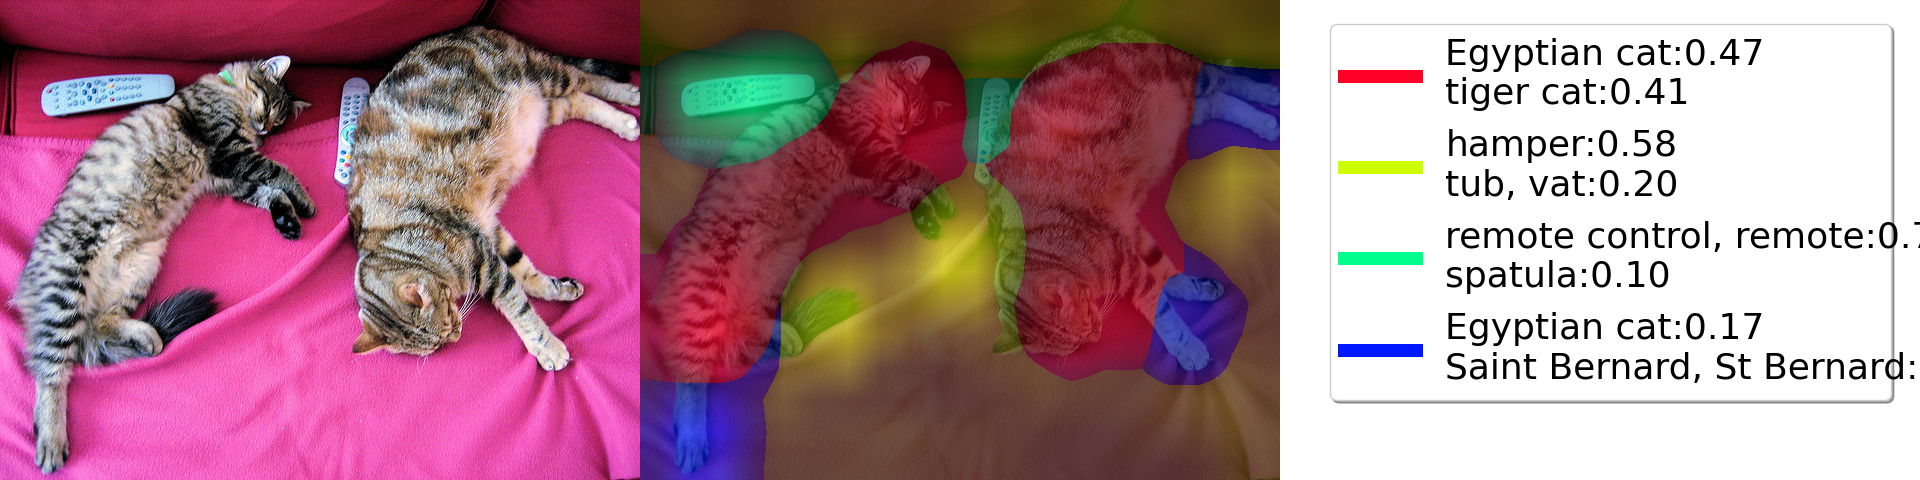

Predicted class 431: bassinet
Predicted class 282: tiger cat
Predicted class 285: Egyptian cat
Predicted class 281: tabby, tabby cat
Predicted class 761: remote control, remote


In [21]:
from transformers import RegNetForImageClassification
model = RegNetForImageClassification.from_pretrained("facebook/regnet-y-040")

# The last layer in the Regnet, note the difference from Resnet.  
target_layer = model.regnet.encoder.stages[-1]
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))
print_top_categories(model, tensor_resized)

#### ViT

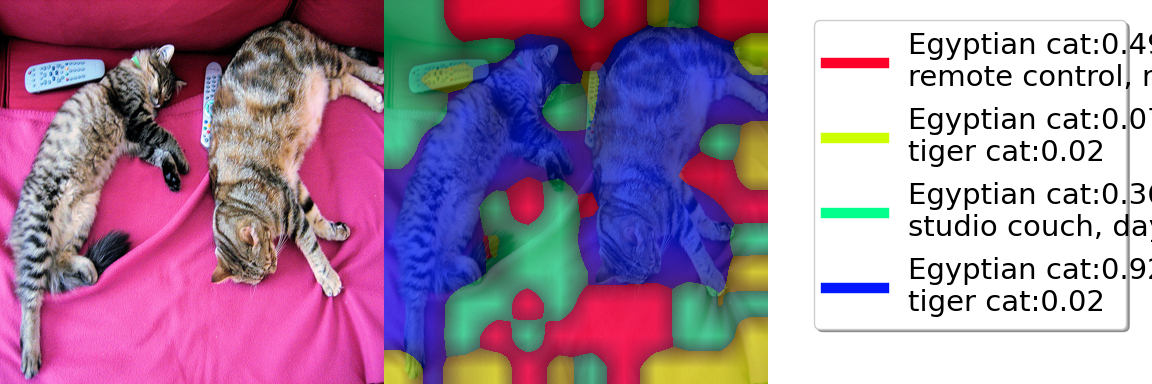

Predicted class 285: Egyptian cat
Predicted class 282: tiger cat
Predicted class 281: tabby, tabby cat
Predicted class 761: remote control, remote
Predicted class 287: lynx, catamount


In [22]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

# The ViT model outputs a sequence of activations, we need to reshape them to a 2D image
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   12, 12, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384')
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]


target_layer = model.vit.layernorm

image_resized = image.resize((384, 384))
tensor_resized = transforms.ToTensor()(image_resized)

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image_resized,
                          img_tensor=tensor_resized,
                          reshape_transform=reshape_transform_vit_huggingface,
                          n_components=4,
                          top_k=2)))
print_top_categories(model, tensor_resized)